**ANALYSE DE LA BASE DE DONNEES OPEN DAMIR**

Cette base de données présente les remboursements de soins effectués par l'ensemble des régimes d'assurance maladie.  \
**Source données** : https://open-data-assurance-maladie.ameli.fr/depenses/download.php?Dir_Rep=Open_DAMIR&Annee=2024  \
**Fichier utilisé** : 'A202412.csv.gz'  \
**Source Fichier Descriptif des variables** : https://www.assurance-maladie.ameli.fr/content/descriptif-des-variables-de-la-serie-open-damir-base-complete

Ce projet s'inscrit dans une démarche personnelle visant à mettre en valeur mes compétences en analyse de données tout en perfectionnant ma maîtrise des outils et des méthodologies. À travers une exploration approfondie, l'objectif est de comprendre et d'analyser les facteurs influençant les dépenses en matière de remboursement par l'assurance maladie, en s'appuyant sur la base de données Open Damir. Cette ressource exhaustive couvre les dépenses des différents régimes d'assurance maladie en France entière depuis janvier 2009, avec des mises à jour régulières et des données mensuelles.

En s'appuyant sur des variables clés telles que les montants dépensés, les montants versé/remboursés, la nature des prestations et l'âge des bénéficiaires, cette analyse cherche à mettre en évidence les liens complexes entre ces différents paramètres.

Grâce à des outils statistiques avancés, des visualisations claires et des approches méthodologiques rigoureuses, ce projet ambitionne de produire des résultats précis et exploitables. Cette démarche permet non seulement de valoriser des compétences analytiques, mais également de renforcer ma compréhension des données de la CPAM et des dynamiques internes liées aux remboursements de prestations.

In [ ]:
# Importation des librairies
import zipfile
import gzip
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import norm

In [4]:
gzip_path = 'H:\\DATA\\Datafiles\\Projets\\CPAM_Data\\A202412.csv.gz'

# Importation des données et du fichier descriptif des variables
data = pd.read_csv(gzip_path, sep=';', compression='gzip')

fichier_excel = "2024_descriptif-variables_open-damir-base-complete.xlsx"
nom_feuille = "MOD OPEN DAMIR"

varmod = pd.read_excel(fichier_excel, sheet_name=nom_feuille)

In [5]:
data.head()

,FLX_ANN_MOI,ORG_CLE_REG,AGE_BEN_SNDS,BEN_RES_REG,BEN_CMU_TOP,BEN_QLT_COD,BEN_SEX_COD,DDP_SPE_COD,ETE_CAT_SNDS,ETE_REG_COD,...,PSE_SPE_SNDS,PSE_STJ_SNDS,PRE_INS_REG,PSP_ACT_SNDS,PSP_ACT_CAT,PSP_SPE_SNDS,PSP_STJ_SNDS,TOP_PS5_TRG,ETB_DCS_MCO,Unnamed: 56
0,202412,84,80,84,0,1,1,121,9999,99,...,0,9,99,0,0,0,9,1,Z,NaN
1,202412,99,40,44,0,1,1,121,9999,99,...,6,1,5,0,1,6,1,1,Z,NaN
2,202412,24,60,24,0,1,1,121,9999,99,...,0,1,99,0,0,11,2,1,Z,NaN
3,202412,52,0,52,0,3,2,121,9999,99,...,0,1,99,0,0,1,2,1,Z,NaN
4,202412,11,60,11,0,1,1,121,9999,99,...,0,1,99,0,0,1,2,1,Z,NaN


In [6]:
# Selection des descriptions de la variable 'PRS_NAT' (nature de prestation)
# Selectionne les deux premières colonnes
varmod_prs_nat = varmod.iloc[:, :2]
varmod_prs_nat.columns = ['variable', 'description']
varmod_prs_nat = varmod_prs_nat.iloc[556:2125, :].reset_index(drop=True)
varmod_prs_nat.head()

,variable,description
0,0,SANS OBJET
1,1039,TELECONSULTATION PEDIATRE 2-6 ANS
2,1040,TELECONSULTATION PEDIATRE 0-2 ANS
3,1041,CONSULT. PSYCHIATRE NEUROLOGUE
4,1042,CONSULTATION PEDIATRE 0-2 ANS


In [7]:
varmod_prs_nat.shape[0]

1569

In [8]:
# Création d'un dictionnaire de la variable 'PRS_NAT'
prsnat_dict = dict(zip(varmod_prs_nat['variable'], varmod_prs_nat['description']))
print(prsnat_dict)

{0: 'SANS OBJET', 1039: 'TELECONSULTATION PEDIATRE 2-6 ANS', 1040: 'TELECONSULTATION PEDIATRE 0-2 ANS', 1041: 'CONSULT. PSYCHIATRE NEUROLOGUE', 1042: 'CONSULTATION PEDIATRE 0-2 ANS', 1043: 'CONSULTATION PEDIATRE 2-6 ANS', 1044: 'CONSULTATION PEDIATRE 6 ANS ET +', 1045: 'EXAM PARENTAL GROSSESSE CO-PARENT', 1046: 'TELECONSULTATION SPECIALISTE', 1047: 'CONSULTATION PSYCHIATRE RAPIDE SUITE ORIENTATION SAS OU MTT', 1048: 'CONSULTATION INIT MT ALD', 1049: 'SUPPL. PEDIATRIQUE URGENCE 2', 1050: 'FORFAIT CONSULTATION URGENCE 0', 1051: 'SUPPL. PEDIATRIQUE URGENCE 1', 1052: 'REMU BIOSIMILAIRE', 1053: 'FORFAIT VSM', 1054: 'BILAN MRTC', 1055: 'SUIVI MRTC', 1056: 'TELECONSULTATION GENERALISTE IVG', 1057: 'TELECONSULTATION SPECIALISTE IVG', 1058: 'EXAMEN OBLIGATOIRE ENFANT COJ', 1059: 'EXAMEN OBLIGATOIRE ENFANT COK', 1060: 'MAJORATION GYNECO MEDICALE', 1061: 'MAJORATION PSY ENFANT', 1062: 'CDE CONGE PARENTAL', 1063: 'CDE CONGE MALADIE', 1064: 'CDE GARANTIE REVENU 1ERE ANNEE', 1065: 'FORFAIT EFFECTEUR

In [9]:
# Création d'un dataframe avec les variables:
# AGE_BEN_SNDS : Tranche d'Age Bénéficiaire au moment des soins,
# PRS_PAI_MNT : Montant payé par les patients, 
# PRS_REM_MNT : Montant versé/remboursé par l'Assurance Maladie, 
# PRS_NAT : Nature de la prestation

ndata = data[['AGE_BEN_SNDS', 'BEN_SEX_COD', 'PRS_ACT_QTE', 'PRS_PAI_MNT', 'PRS_REM_MNT', 'PRS_NAT']].copy()
ndata.loc[:, 'PRS_NAT_DESC'] = ndata['PRS_NAT'].map(prsnat_dict)
ndata['DIFF']= ndata['PRS_PAI_MNT'] - abs(ndata['PRS_REM_MNT'])

df = pd.DataFrame(ndata)
df.head()

,AGE_BEN_SNDS,BEN_SEX_COD,PRS_ACT_QTE,PRS_PAI_MNT,PRS_REM_MNT,PRS_NAT,PRS_NAT_DESC,DIFF
0,80,1,2,2.70,2.70,3116,MAJORATION POUR ACTE UNIQUE,0.00
1,40,1,3,0.00,-6.00,1952,PARTICIPATION FORFAITAIRE TIERS PAYANT,-6.00
2,60,1,3,120.12,120.12,3132,ACTES DES ORTHOPHONISTES,0.00
3,0,2,2,60.32,36.20,3132,ACTES DES ORTHOPHONISTES,24.12
4,60,1,2,0.00,-2.00,1976,FRANCHISE TIERS PAYANT ACTE D'AUXILIAIRE MEDICAUX,-2.00


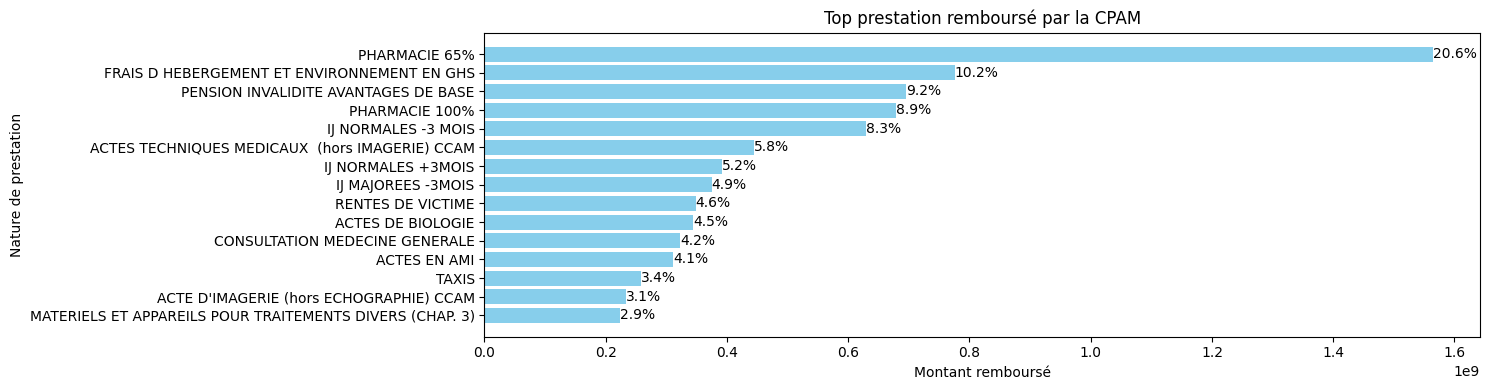

In [10]:
grouped_data = df.groupby('PRS_NAT_DESC')['PRS_REM_MNT'].sum().reset_index()
top_prs_rem = grouped_data.sort_values(by='PRS_REM_MNT', ascending=False).head(15)
top_prs_rem['Percentage'] = (top_prs_rem['PRS_REM_MNT'] / top_prs_rem['PRS_REM_MNT'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(15, 4)) 
plt.barh(top_prs_rem['PRS_NAT_DESC'], top_prs_rem['PRS_REM_MNT'], color='skyblue')

# Pourcentages sur les barres
for index, value in enumerate(top_prs_rem['PRS_REM_MNT']):
    percentage = f"{top_prs_rem['Percentage'].iloc[index]:.1f}%" 
    plt.text(value, index, percentage, va='center')


plt.xlabel('Montant remboursé')
plt.ylabel('Nature de prestation')
plt.title('Top prestation remboursé par la CPAM')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

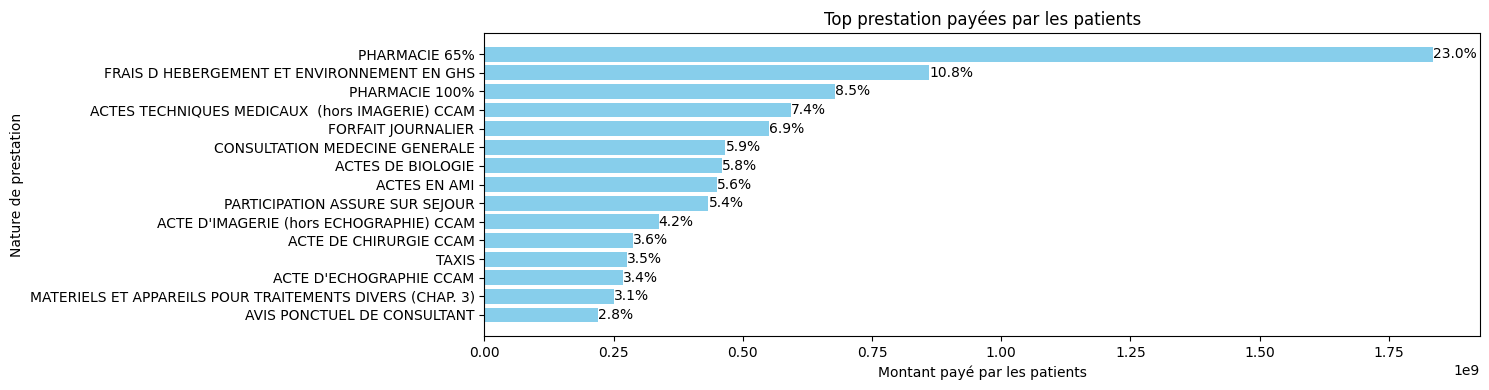

In [11]:
grouped_data_pai = df.groupby('PRS_NAT_DESC')['PRS_PAI_MNT'].sum().reset_index()
top_prs_pai = grouped_data_pai.sort_values(by='PRS_PAI_MNT', ascending=False).head(15)
top_prs_pai['Percentage'] = (top_prs_pai['PRS_PAI_MNT'] / top_prs_pai['PRS_PAI_MNT'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(15, 4)) 
plt.barh(top_prs_pai['PRS_NAT_DESC'], top_prs_pai['PRS_PAI_MNT'], color='skyblue')

# Pourcentages sur les barres
for index, value in enumerate(top_prs_pai['PRS_PAI_MNT']):
    percentage = f"{top_prs_pai['Percentage'].iloc[index]:.1f}%" 
    plt.text(value, index, percentage, va='center')


plt.xlabel('Montant payé par les patients')
plt.ylabel('Nature de prestation')
plt.title('Top prestation payées par les patients')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

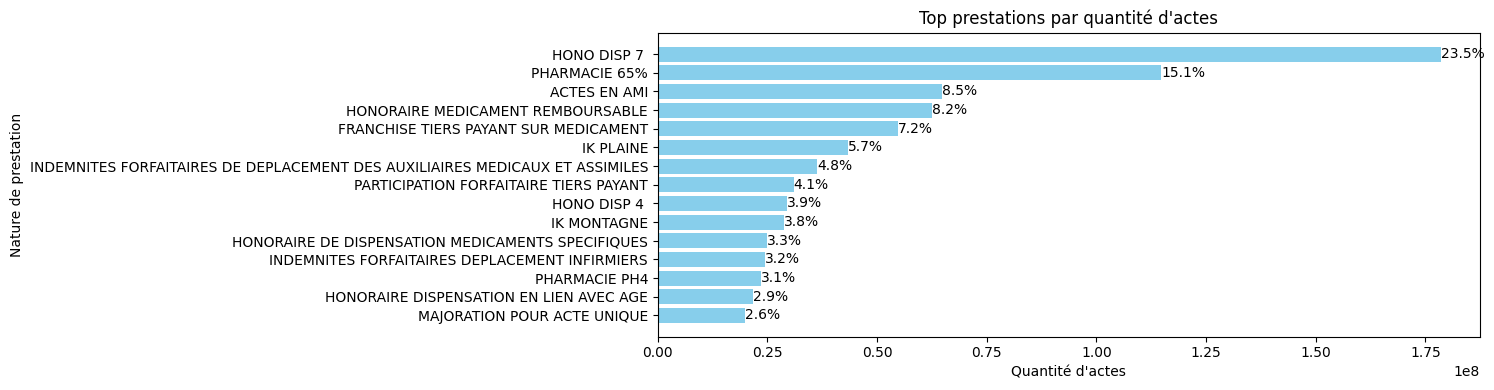

In [12]:
grouped_data_act = df.groupby('PRS_NAT_DESC')['PRS_ACT_QTE'].sum().reset_index()
top_prs_act = grouped_data_act.sort_values(by='PRS_ACT_QTE', ascending=False).head(15)
top_prs_act['Percentage'] = (top_prs_act['PRS_ACT_QTE'] / top_prs_act['PRS_ACT_QTE'].sum()) * 100

# Diagramme en barres horizontal
plt.figure(figsize=(15, 4)) 
plt.barh(top_prs_act['PRS_NAT_DESC'], top_prs_act['PRS_ACT_QTE'], color='skyblue')

# Pourcentages sur les barres
for index, value in enumerate(top_prs_act['PRS_ACT_QTE']):
    percentage = f"{top_prs_act['Percentage'].iloc[index]:.1f}%" 
    plt.text(value, index, percentage, va='center')


plt.xlabel('Quantité d\'actes')
plt.ylabel('Nature de prestation')
plt.title('Top prestations par quantité d\'actes')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

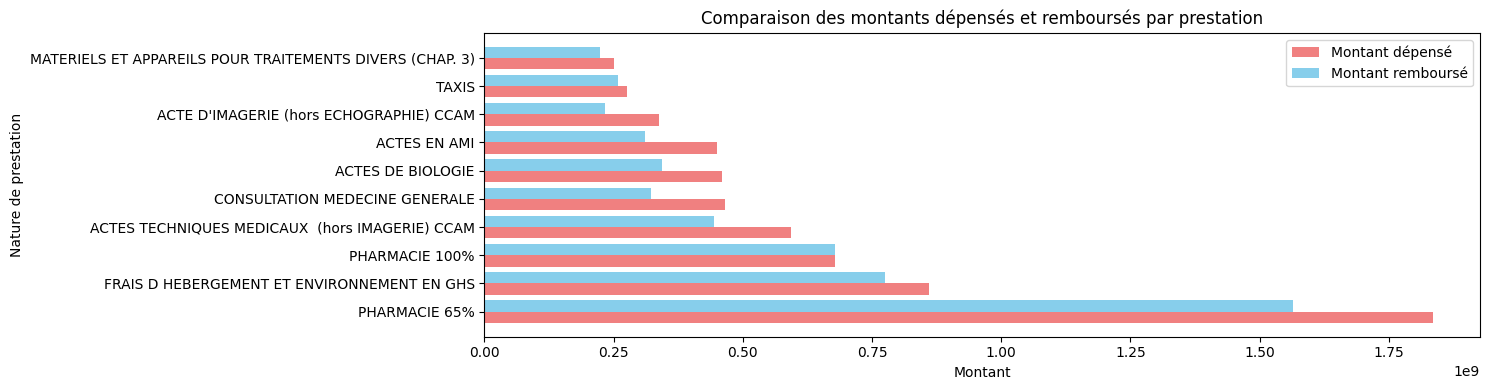

In [13]:
# Fusionner les deux DataFrames pour avoir les mêmes catégories
merged_data = pd.merge(
    top_prs_pai[['PRS_NAT_DESC', 'PRS_PAI_MNT']].rename(columns={'PRS_PAI_MNT': 'Montant dépensé'}),
    top_prs_rem[['PRS_NAT_DESC', 'PRS_REM_MNT']].rename(columns={'PRS_REM_MNT': 'Montant remboursé'}),
    on='PRS_NAT_DESC',
    how='inner'
).sort_values(by='Montant dépensé', ascending=False)

# Création des positions pour les barres
x = np.arange(len(merged_data['PRS_NAT_DESC'])) 
width = 0.4 

# Tracer les barres
plt.figure(figsize=(15, 4))
plt.barh(x - width/2, merged_data['Montant dépensé'], height=width, label='Montant dépensé', color='lightcoral')
plt.barh(x + width/2, merged_data['Montant remboursé'], height=width, label='Montant remboursé', color='skyblue')

# Ajouter les labels
plt.yticks(x, merged_data['PRS_NAT_DESC'])
plt.xlabel('Montant')
plt.ylabel('Nature de prestation')
plt.title('Comparaison des montants dépensés et remboursés par prestation')
plt.legend()

# Ajuster l'affichage
plt.tight_layout()
plt.show()


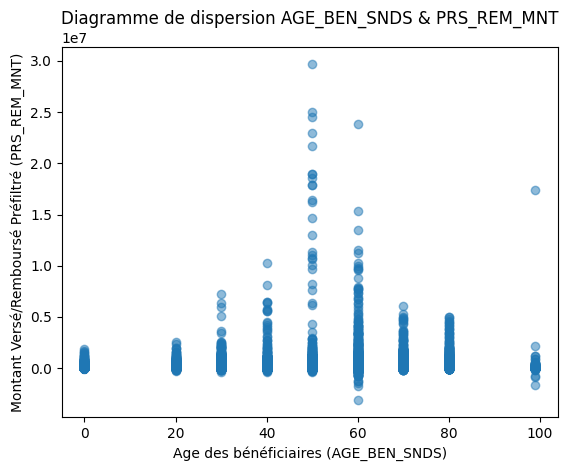

In [14]:
# Diagramme de dispersion
plt.scatter(df['AGE_BEN_SNDS'], df['PRS_REM_MNT'], alpha=0.5)

# Labels et titre
plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel('Montant Versé/Remboursé Préfiltré (PRS_REM_MNT)')
plt.title('Diagramme de dispersion AGE_BEN_SNDS & PRS_REM_MNT')

plt.show()

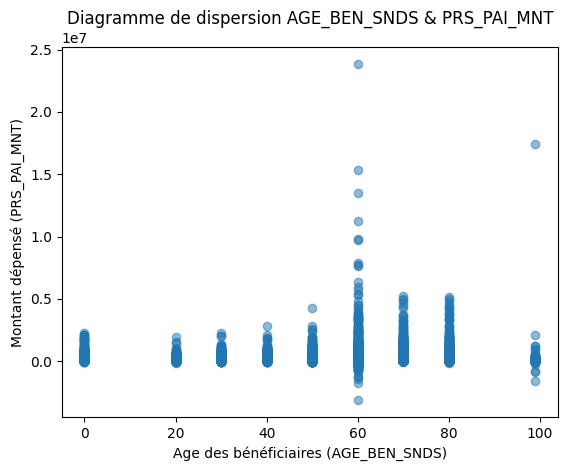

In [15]:
# Diagramme de dispersion
plt.scatter(df['AGE_BEN_SNDS'], df['PRS_PAI_MNT'], alpha=0.5)

# Labels et titre
plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel('Montant dépensé (PRS_PAI_MNT)')
plt.title('Diagramme de dispersion AGE_BEN_SNDS & PRS_PAI_MNT')

plt.show()

In [16]:
# Aggregating data by 'AGE_BEN_SNDS' and summing 'PRS_REM_MNT'
agg_data_rem = df.groupby('AGE_BEN_SNDS')['PRS_REM_MNT'].sum().reset_index()
agg_data_pai = df.groupby('AGE_BEN_SNDS')['PRS_PAI_MNT'].sum().reset_index()
agg_data_qte = df.groupby('AGE_BEN_SNDS')['PRS_ACT_QTE'].sum().reset_index()
agg_data_merged = pd.merge(agg_data_rem, agg_data_pai, on='AGE_BEN_SNDS', suffixes=('_REM', '_PAI'))

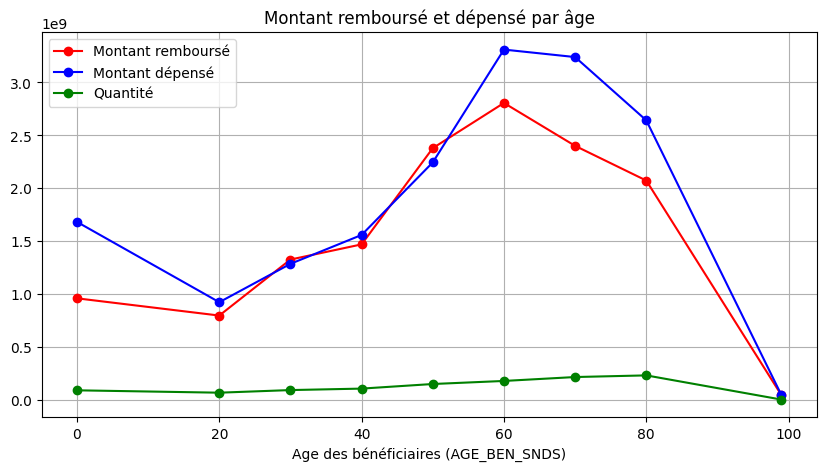

In [ ]:
# PLOT agg_data_merged
plt.figure(figsize=(10, 5))
plt.plot(agg_data_merged['AGE_BEN_SNDS'], agg_data_merged['PRS_REM_MNT'], color='red', marker='o', label='Montant remboursé')
plt.plot(agg_data_merged['AGE_BEN_SNDS'], agg_data_merged['PRS_PAI_MNT'], color='blue', marker='o', label='Montant dépensé')
plt.plot(agg_data_merged['AGE_BEN_SNDS'], agg_data_qte['PRS_ACT_QTE'], color='green', marker='o', label='Nombre d\'actes')
plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel(None)
plt.title('Montant remboursé et dépensé par âge')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# PLOT agg_data_merged
plt.figure(figsize=(10, 5))
plt.plot(df['BEN_SEX_COD'] == 1, df['PRS_REM_MNT'], color='red', marker='o', label='Montant remboursé')
plt.plot(df['BEN_SEX_COD'] == 2, df['PRS_PAI_MNT'], color='blue', marker='o', label='Montant dépensé')
plt.plot(df['BEN_SEX_COD'] == 0, df['PRS_ACT_QTE'], color='green', marker='o', label='Quantité')
plt.xlabel('')
plt.ylabel(None)
plt.title('Montant remboursé par sexe')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\saeru\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


: 

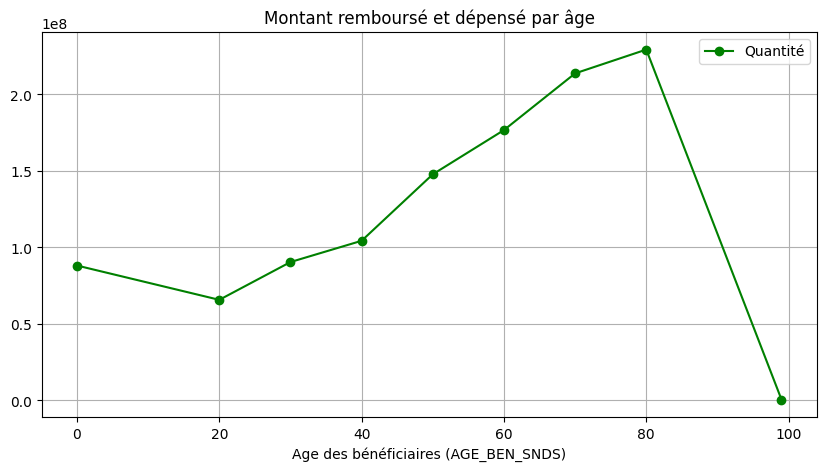

In [18]:
# PLOT agg_data_merged
plt.figure(figsize=(10, 5))
plt.plot(agg_data_merged['AGE_BEN_SNDS'], agg_data_qte['PRS_ACT_QTE'], color='green', marker='o', label='Quantité')
plt.xlabel('Age des bénéficiaires (AGE_BEN_SNDS)')
plt.ylabel(None)
plt.title('Montant remboursé et dépensé par âge')
plt.legend()
plt.grid(True)
plt.show()

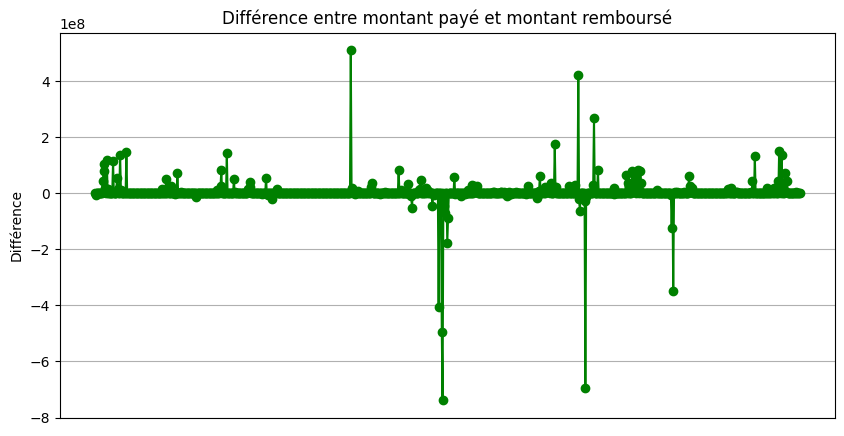

In [19]:
# plot DIFF
diff_data = df.groupby('PRS_NAT_DESC')['DIFF'].sum().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(diff_data['PRS_NAT_DESC'], diff_data['DIFF'], color='green', marker='o')

plt.xticks([])
plt.xlabel(None)
plt.ylabel('Différence')
plt.title('Différence entre montant payé et montant remboursé')
plt.grid(True)
plt.show()

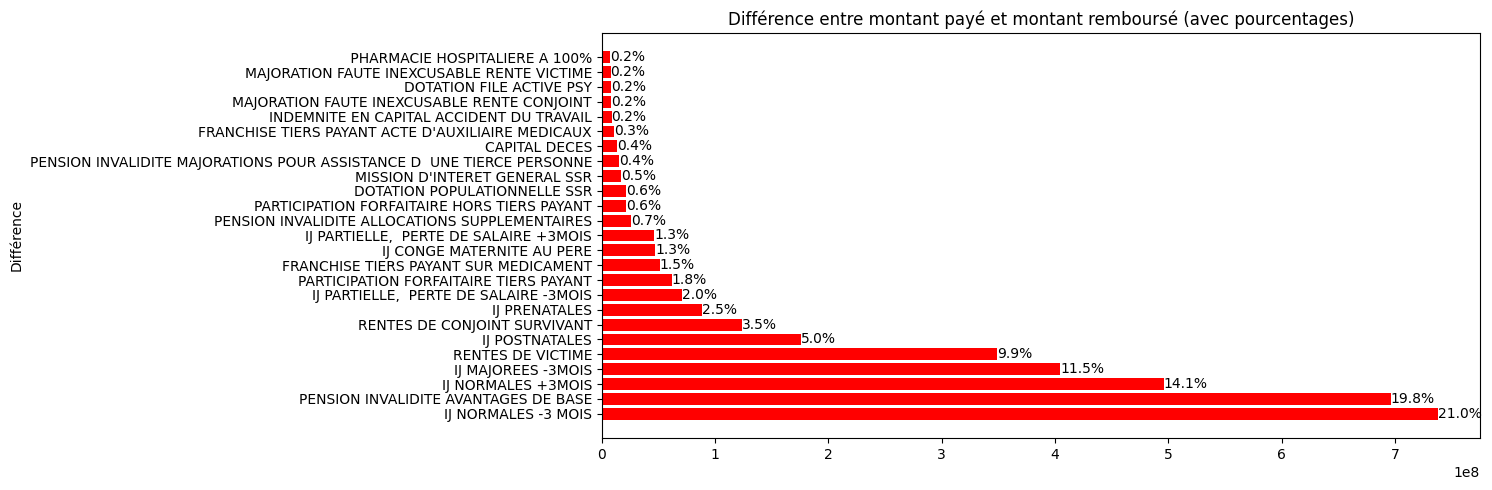

In [20]:
# Filtrer les données avec des différences négatives, les trier et calculer les pourcentages
negative_diff_data = diff_data[diff_data['DIFF'] < 0].sort_values(by='DIFF', ascending=True).head(25).reset_index(drop=True)
negative_diff_data['DIFF'] = negative_diff_data['DIFF'].abs()
negative_diff_data['Percentage'] = (negative_diff_data['DIFF'] / negative_diff_data['DIFF'].sum()) * 100

# Créer le graphique en barres horizontales
plt.figure(figsize=(15, 5))
plt.barh(negative_diff_data['PRS_NAT_DESC'], negative_diff_data['DIFF'], color='red')

# Ajouter les pourcentages sur les barres
for index, value in enumerate(negative_diff_data['DIFF']):
    percentage = f"{negative_diff_data['Percentage'].iloc[index]:.1f}%"
    plt.text(value, index, percentage, va='center', ha='left')  # Ajouter le texte à la droite de chaque barre

# Supprimer l'étiquette de l'axe X
plt.xlabel(None)

# Ajouter un titre et une étiquette pour l'axe Y
plt.ylabel('Différence')
plt.title('Différence entre montant payé et montant remboursé (avec pourcentages)')

# Afficher le graphique
plt.tight_layout()
plt.show()


In [21]:
age50_60 = df[(df['AGE_BEN_SNDS'] == 50) | (df['AGE_BEN_SNDS'] == 60)]

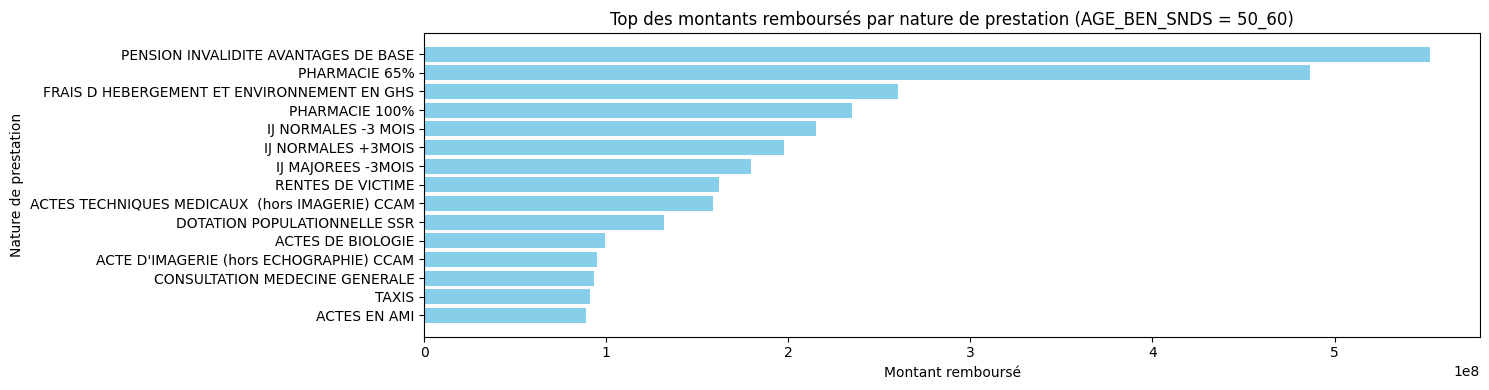

In [22]:
# Regrouper les données par 'Description' et calculer la somme des valeurs
grouped_age_rem = age50_60.groupby('PRS_NAT_DESC')['PRS_REM_MNT'].sum().reset_index()

# Trier les données par 'FLT_REM_MNT' dans l'ordre décroissant
top_age_rem = grouped_age_rem.sort_values(by='PRS_REM_MNT', ascending=False).head(15)

# Tracer un diagramme en barres horizontal pour les 50 plus hautes prestations
plt.figure(figsize=(15, 4))  # Augmenter la hauteur pour une meilleure lisibilité
plt.barh(top_age_rem['PRS_NAT_DESC'], top_age_rem['PRS_REM_MNT'], color='skyblue')

# Ajouter des labels et un titre
plt.xlabel('Montant remboursé')
plt.ylabel('Nature de prestation')
plt.title('Top des montants remboursés par nature de prestation (AGE_BEN_SNDS = 50_60)')

# Inverser l'ordre pour afficher les barres du plus grand au plus petit
plt.gca().invert_yaxis()

# Afficher le graphique
plt.tight_layout()  # Pour ajuster les marges automatiquement
plt.show()

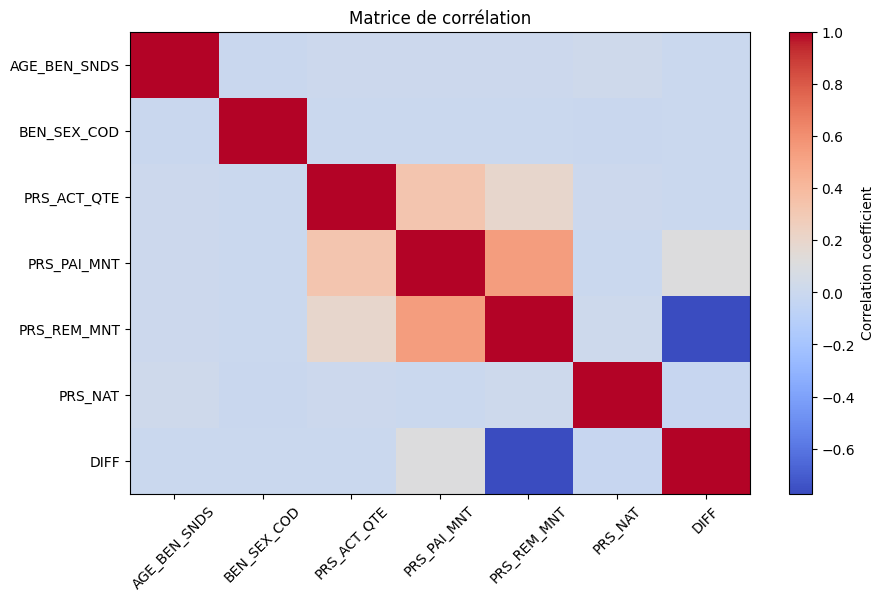

In [23]:
# Matrice de corrélation (exclure les colonnes non numériques)
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Tracer la matrice de corrélation
plt.figure(figsize=(10, 6))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation coefficient')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Matrice de corrélation')
plt.show()

In [31]:
reg_data = pd.get_dummies(df, columns=['BEN_SEX_COD'], drop_first=True)

# Ensure all columns used in regression are numeric
X = reg_data[['AGE_BEN_SNDS', 'PRS_ACT_QTE', 'PRS_PAI_MNT', 'BEN_SEX_COD_2']].apply(pd.to_numeric)
y = reg_data['PRS_REM_MNT'].apply(pd.to_numeric)

# Convert boolean columns to integers
X['BEN_SEX_COD_2'] = X['BEN_SEX_COD_2'].astype(int)

# Ajouter une constante pour l'interception (ordonnée à l'origine)
X = sm.add_constant(X)

# Ajuster le modèle de régression linéaire
model = sm.OLS(y, X).fit()

# Résumé des résultats
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            PRS_REM_MNT   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 3.692e+06
Date:                Fri, 21 Mar 2025   Prob (F-statistic):               0.00
Time:                        01:06:53   Log-Likelihood:            -4.0357e+08
No. Observations:            36197289   AIC:                         8.071e+08
Df Residuals:                36197284   BIC:                         8.071e+08
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5864      6.636      0.239

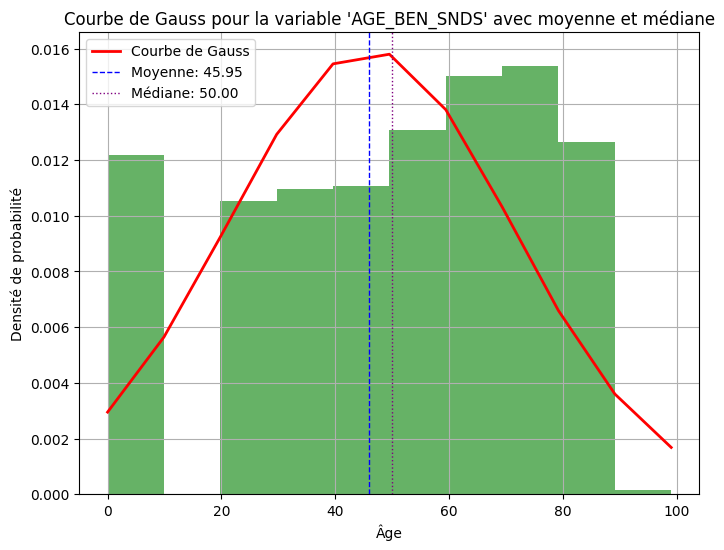

In [25]:
# Calcul des paramètres de la distribution normale (moyenne et écart-type)
mu, sigma = df['AGE_BEN_SNDS'].mean(), df['AGE_BEN_SNDS'].std()
median = df['AGE_BEN_SNDS'].median()

# Tracé de l'histogramme des âges
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(df['AGE_BEN_SNDS'], bins=10, density=True, alpha=0.6, color='g')

# Calcul de la courbe de Gauss
gauss_curve = norm.pdf(bins, mu, sigma)

# Tracé de la courbe de Gauss
plt.plot(bins, gauss_curve, linewidth=2, color='r', label='Courbe de Gauss')
# Ajout des lignes pour la moyenne et la médiane
plt.axvline(mu, color='b', linestyle='dashed', linewidth=1, label=f'Moyenne: {mu:.2f}')
plt.axvline(median, color='#800080', linestyle='dotted', linewidth=1, label=f'Médiane: {median:.2f}')
plt.title("Courbe de Gauss pour la variable 'AGE_BEN_SNDS' avec moyenne et médiane")
plt.xlabel("Âge")
plt.ylabel("Densité de probabilité")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Calcul des statistiques descriptives

statistiques_descriptives = {
'moyenne': df['AGE_BEN_SNDS'].mean(),
'médiane': df['AGE_BEN_SNDS'].median(),
'mode': df['AGE_BEN_SNDS'].mode().values[0],
'écart_type': df['AGE_BEN_SNDS'].std(),
'minimum': df['AGE_BEN_SNDS'].min(),
'maximum': df['AGE_BEN_SNDS'].max(),
'quantiles': df['AGE_BEN_SNDS'].quantile([0.25, 0.5, 0.75]).to_dict(),
'variance': df['AGE_BEN_SNDS'].var(),
'skewness': df['AGE_BEN_SNDS'].skew(),
'kurtosis': df['AGE_BEN_SNDS'].kurtosis()
}
# Affichage des statistiques descriptives
for stat, valeur in statistiques_descriptives.items(): 
    print(f'{stat}: {valeur}')

moyenne: 45.94771357048314
médiane: 50.0
mode: 70
écart_type: 25.001137652877905
minimum: 0
maximum: 99
quantiles: {0.25: 30.0, 0.5: 50.0, 0.75: 70.0}
variance: 625.0568839381493
skewness: -0.40108237390696294
kurtosis: -0.879663336825351
